In [111]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, BatchNormalization
from common import sns_cm, plot_loss_accuracy, get_set
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback
import pandas as pd
import math
import tensorflow as tf
from pathlib import Path
import numpy as np

#### Parses the model names.

In [112]:
def parse_key(title):
    parts = title.split(", ")
    
    # Parse the key to get the number of neurons, layers, and timesteps
    neuron = int(parts[0].split(": ")[1])
    layer = int(parts[1].split(": ")[1])
    timestep = int(parts[2].split(": ")[1])
    
    return neuron, layer, timestep

### A callback to stop training if accuracy > 98% and loss < 20%

In [113]:
def map_to_100(data, return_data=False):
    count = math.floor(data['class'].value_counts().min() / 100) * 100
    balanced_data = data.groupby('class').apply(lambda x: x.sample(count)).reset_index(drop=True)
    return (balanced_data.drop('class', axis='columns').to_numpy(), pd.get_dummies(balanced_data['class'], columns=['class']).to_numpy()) if not return_data else balanced_data

In [114]:
def process_data(path):
    data_list = []
    for _class in Path(path).rglob("*"):
        temp_df = pd.read_pickle(str(_class))
        temp_df['class'] = str(_class.name)[:-1]
        data_list.append(temp_df)
    return data_list

In [115]:
movement_positions: list[str] = ['Walking', 'Jumping', 'Running', 'Squats']

training_sets = get_set(positions=movement_positions, folder='Class Dataframes')
testing_sets = get_set(positions=movement_positions, folder='Test')
testing_set = pd.concat(testing_sets, axis='rows', ignore_index=True)
df = pd.concat(training_sets, axis='rows', ignore_index=True)

In [116]:
my_train = df
my_test = testing_set

In [117]:
class_mapping = {
    "Jump": "Jumping_Per",
    "Running": "Running_Per",
    "Walk": "Walking_Per",
    "Spinning": "Spinning_Per"
}

per_train = pd.concat(process_data("Per/training"), axis='rows', ignore_index=True)
per_test = pd.concat(process_data("Per/test"), axis='rows', ignore_index=True)

# Use the replace() function on the 'Class' column
per_train['class'] = per_train['class'].replace(class_mapping)
per_test['class'] = per_test['class'].replace(class_mapping)

In [118]:
training_X, training_y = map_to_100(
    pd.concat([my_train, per_train], axis='rows',
              ignore_index=True))
X_test, y_test = map_to_100(
    pd.concat([testing_set, per_test], axis='rows',
              ignore_index=True))

### This reshapes the data and makes sure that each window has data from the same class

In [119]:
def reshape_data(time_step, X_train, X_val, y_train, y_val):
    X_train_reshaped_list = []
    X_val_reshaped_list = []
    y_train_reshaped_list = []
    y_val_reshaped_list = []

    # Get unique classes
    classes = np.unique(np.argmax(y_train, axis=1))

    # Iterate over each class
    for class_id in classes:
        # Get data for this class
        X_train_this_class = X_train[np.argmax(y_train, axis=1) == class_id]
        X_val_this_class = X_val[np.argmax(y_val, axis=1) == class_id]
        y_train_this_class = y_train[np.argmax(y_train, axis=1) == class_id]
        y_val_this_class = y_val[np.argmax(y_val, axis=1) == class_id]

        # Calculate the number of samples that fit into the time_step
        num_samples_train = len(X_train_this_class) // time_step * time_step
        num_samples_val = len(X_val_this_class) // time_step * time_step

        # Reshape the data according to the time_step
        X_train_reshaped = X_train_this_class[:num_samples_train].reshape(-1, time_step, X_train.shape[1])
        X_val_reshaped = X_val_this_class[:num_samples_val].reshape(-1, time_step, X_val.shape[1])
        y_train_reshaped = y_train_this_class[:num_samples_train].reshape(-1, time_step, y_train.shape[1])
        y_val_reshaped = y_val_this_class[:num_samples_val].reshape(-1, time_step, y_val.shape[1])

        # Append reshaped data to lists
        X_train_reshaped_list.append(X_train_reshaped)
        X_val_reshaped_list.append(X_val_reshaped)
        y_train_reshaped_list.append(y_train_reshaped)
        y_val_reshaped_list.append(y_val_reshaped)

    # Concatenate reshaped data for all classes
    X_train_reshaped_all_classes = np.concatenate(X_train_reshaped_list)
    X_val_reshaped_all_classes = np.concatenate(X_val_reshaped_list)
    y_train_reshaped_all_classes = np.concatenate(y_train_reshaped_list)
    y_val_reshaped_all_classes = np.concatenate(y_val_reshaped_list)

    return X_train_reshaped_all_classes, X_val_reshaped_all_classes, y_train_reshaped_all_classes, y_val_reshaped_all_classes


In [120]:
def reshape_test(time_step, _X_test, _y_test):
    X_test_reshaped_list = []
    y_test_reshaped_list = []

    # Get unique classes
    classes = np.unique(np.argmax(_y_test, axis=1))

    # Iterate over each class
    for class_id in classes:
        X_test_this_class = _X_test[np.argmax(_y_test, axis=1) == class_id]
        y_test_this_class = _y_test[np.argmax(_y_test, axis=1) == class_id]

        num_samples_test = len(X_test_this_class) // time_step * time_step

        # Reshape the data according to the time_step
        X_test_reshaped = X_test_this_class[:num_samples_test].reshape(-1, time_step, _X_test.shape[1])
        y_test_reshaped = y_test_this_class[:num_samples_test].reshape(-1, time_step, _y_test.shape[1])

        # Append reshaped data to lists
        X_test_reshaped_list.append(X_test_reshaped)
        y_test_reshaped_list.append(y_test_reshaped)

    # Concatenate reshaped data for all classes
    X_test_reshaped_all_classes = np.concatenate(X_test_reshaped_list)
    y_test_reshaped_all_classes = np.concatenate(y_test_reshaped_list)

    return X_test_reshaped_all_classes, y_test_reshaped_all_classes
        

## Classification of the four movement classes

### You should use RNN as a classifier. To save time we will just use the GRU neuron. Hyperparameters you can change for optimizing are:
##### — Number of neurons in each layer. You need to provide result for at least three different sizes of a layer
##### — Number of layers. We can limit ourself to 1 and 2 layers.
##### — Window length, You need to provide result for at least 3 different window lengths
##### This does mean that you need to train 2 x 3 x 3 models.

### Hyperparameters

In [121]:
neurons = [20, 40, 60, 80, 100]
layers = [1, 2, 3, 4, 5]
time_steps = [25, 50, 100]  # Number of previous time steps used to predict each step.
training_scores = {}

### Model information

In [122]:
models = {}
histories = {}
sets = {}
test_sets = {}

### Reshape the training data, pre-populate sets

In [123]:
for i in time_steps:
    X_train, X_val, y_train, y_val = train_test_split(training_X, training_y, test_size=0.30, shuffle=False)
    X_train, X_val, y_train, y_val = reshape_data(i, X_train, X_val, y_train, y_val)
    sets[i] = X_train, X_val, y_train, y_val

### Reshape the testing data, pre-populate test_sets

In [124]:
for i in time_steps:
    _X_test, _y_test = reshape_test(i, X_test, y_test)
    test_sets[i] = _X_test, _y_test

### Reshape the new raw data, pre-populate test_sets

### Create the models

In [125]:
for n in neurons:
    for layer in layers:
        for timestep in time_steps:
            model = Sequential()
            X_train, X_val, y_train, y_val = sets[timestep]

            model.add(
                GRU(
                    units=n,
                    return_sequences=True,
                    input_shape=(timestep, X_train.shape[2])
                )
            )

            for _ in range(layer - 1):
                model.add(
                    GRU(
                        units=n,
                        activation='relu',
                        return_sequences=True))

                model.add(
                    Dropout(
                        rate=0.3
                    )
                )

                model.add(
                    BatchNormalization()
                )

            model.add(Dense(8, activation='softmax'))

            sets[f"model - neurons: {n}, layers: {layer}, win_len: {timestep}"] = (X_train, X_val, y_train, y_val)
            models[f"model - neurons: {n}, layers: {layer}, win_len: {timestep}"] = model

### Show the models

In [126]:
for model in models.values():
    model.summary()

Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_450 (GRU)               (None, 25, 20)            1680      
                                                                 
 dense_150 (Dense)           (None, 25, 8)             168       
                                                                 
Total params: 1,848
Trainable params: 1,848
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_451 (GRU)               (None, 50, 20)            1680      
                                                                 
 dense_151 (Dense)           (None, 50, 8)             168       
                                                                 
Total params: 1,848
Traina

### Compile the models

In [127]:
for model in models.values():
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the models

In [128]:
epochs = 150

In [129]:
%%capture
for key, model in models.items():
    X_train, X_val, y_train, y_val = sets[key]

    # Add callback: callbacks=[my_callback] for faster performance.
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs).history
    histories[key] = history

### Plot loss and accuracy for validation and training set.

In [130]:
%%capture
for key, history in histories.items():
    plot_loss_accuracy(history=history, name=key, same_graph=True)

### Accuracy as a function of parameters.

In [131]:
def plot_metrics(metric, is_train=False):
    global training_scores, models, histories

    # Create empty lists to hold max metric values
    max_metric_neurons = []
    max_metric_layers = []
    max_metric_timesteps = []

    # Iterate over models
    for key in models.keys():
        neuron, layer, timestep = parse_key(key)

        if is_train:
            history = training_scores[key]
            max_metric = history[1] if metric == 'accuracy' else history[0]
        else:
            # Get the corresponding history
            history = histories[key]
            # Get the max metric value
            max_metric = max(history[metric])

        # Append max metric value to a corresponding list
        if neuron not in [i[0] for i in max_metric_neurons]:
            max_metric_neurons.append((neuron, max_metric))
        if layer not in [i[0] for i in max_metric_layers]:
            max_metric_layers.append((layer, max_metric))
        if timestep not in [i[0] for i in max_metric_timesteps]:
            max_metric_timesteps.append((timestep, max_metric))

    # Sort lists by neurons/layers/timesteps
    max_metric_neurons.sort(key=lambda x: x[0])
    max_metric_layers.sort(key=lambda x: x[0])
    max_metric_timesteps.sort(key=lambda x: x[0])

    # Create plots
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot([i[0] for i in max_metric_neurons], [i[1] for i in max_metric_neurons])
    plt.title(f'Max {metric} vs Neurons')
    plt.xlabel('Neurons')
    plt.ylabel(f'Max {metric}')

    plt.subplot(1, 3, 2)
    plt.plot([i[0] for i in max_metric_layers], [i[1] for i in max_metric_layers])
    plt.title(f'Max {metric} vs Layers')
    plt.xlabel('Layers')
    plt.ylabel(f'Max {metric}')

    plt.subplot(1, 3, 3)
    plt.plot([i[0] for i in max_metric_timesteps], [i[1] for i in max_metric_timesteps])
    plt.title(f'Max {metric} vs Timesteps')
    plt.xlabel('Timesteps')
    plt.ylabel(f'Max {metric}')

    plt.tight_layout()
    plt.show()


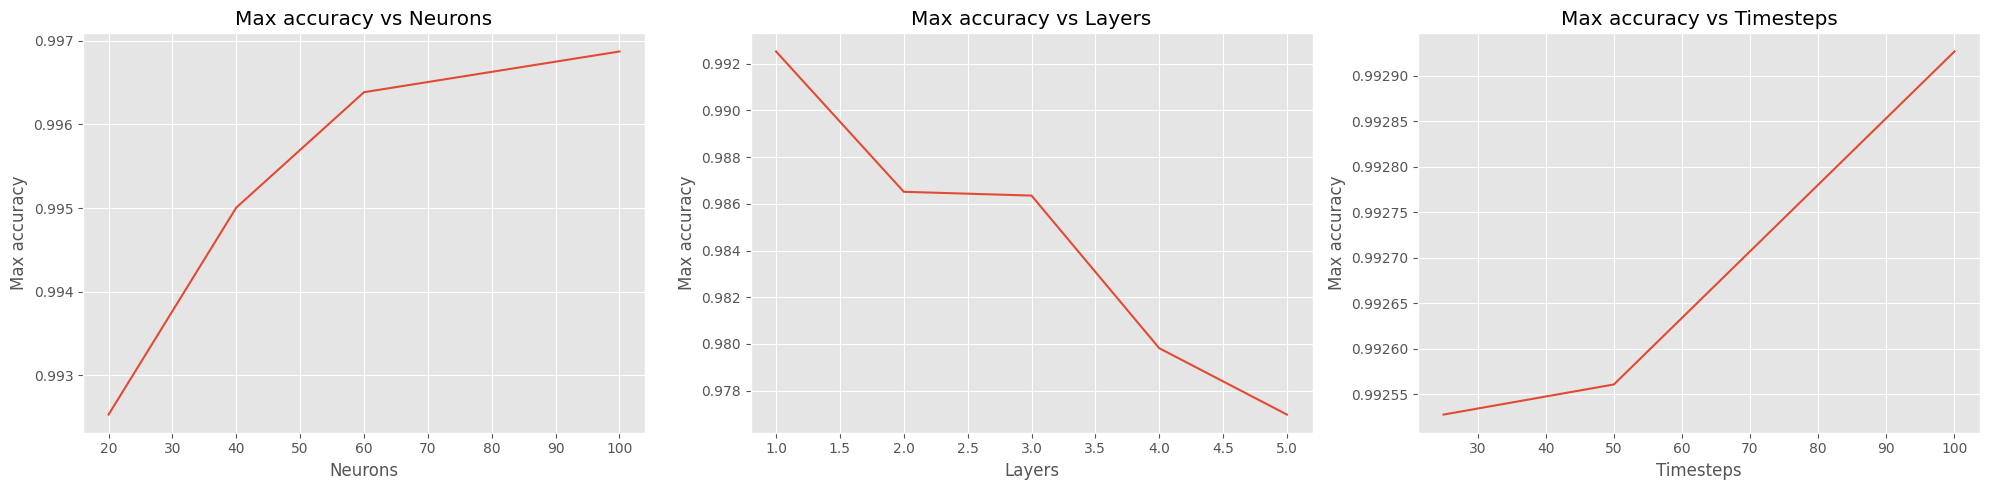

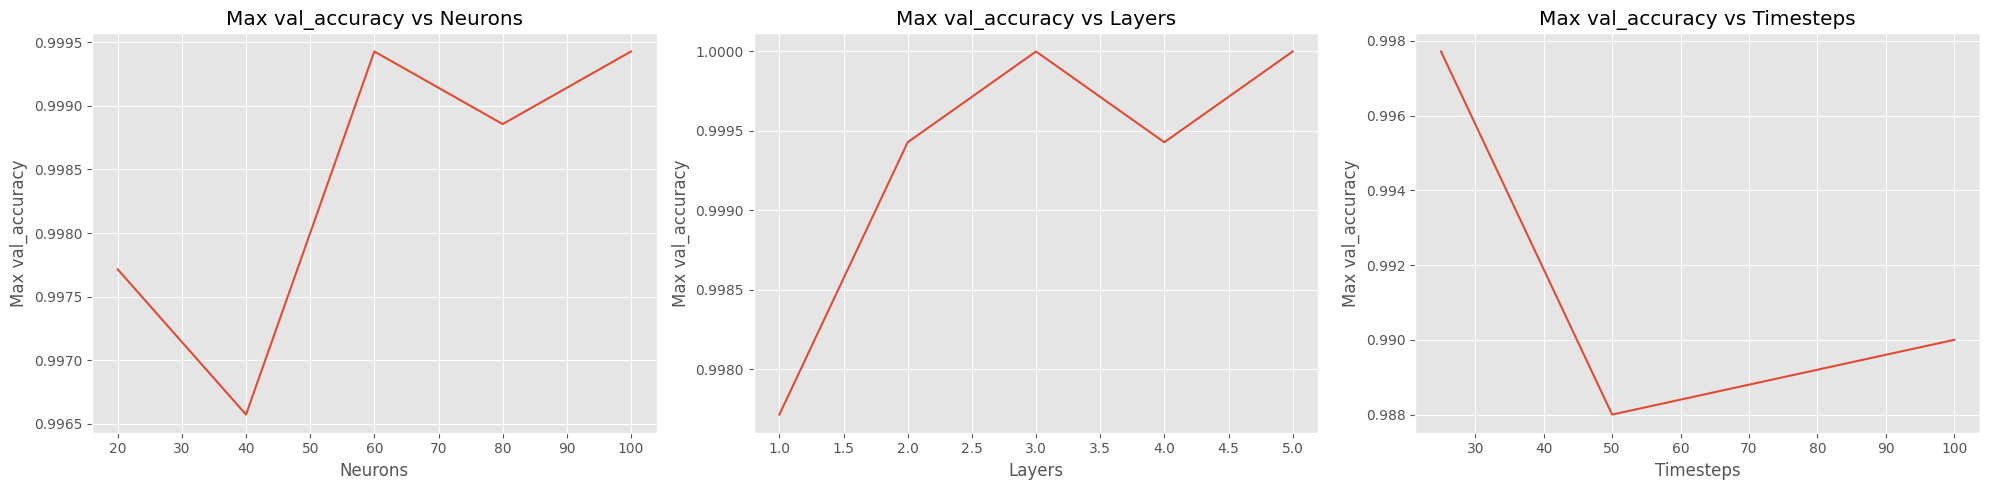

In [132]:
plot_metrics(metric='accuracy')
plot_metrics(metric='val_accuracy')

### Accuracies

In [133]:
%%capture
for key, model in models.items():
    _, _, timestep = parse_key(key)
    _x, _y = test_sets[timestep]
    training_scores[key] = model.evaluate(_x, _y)

### Plot accuracy and loss as a function of each parameter.

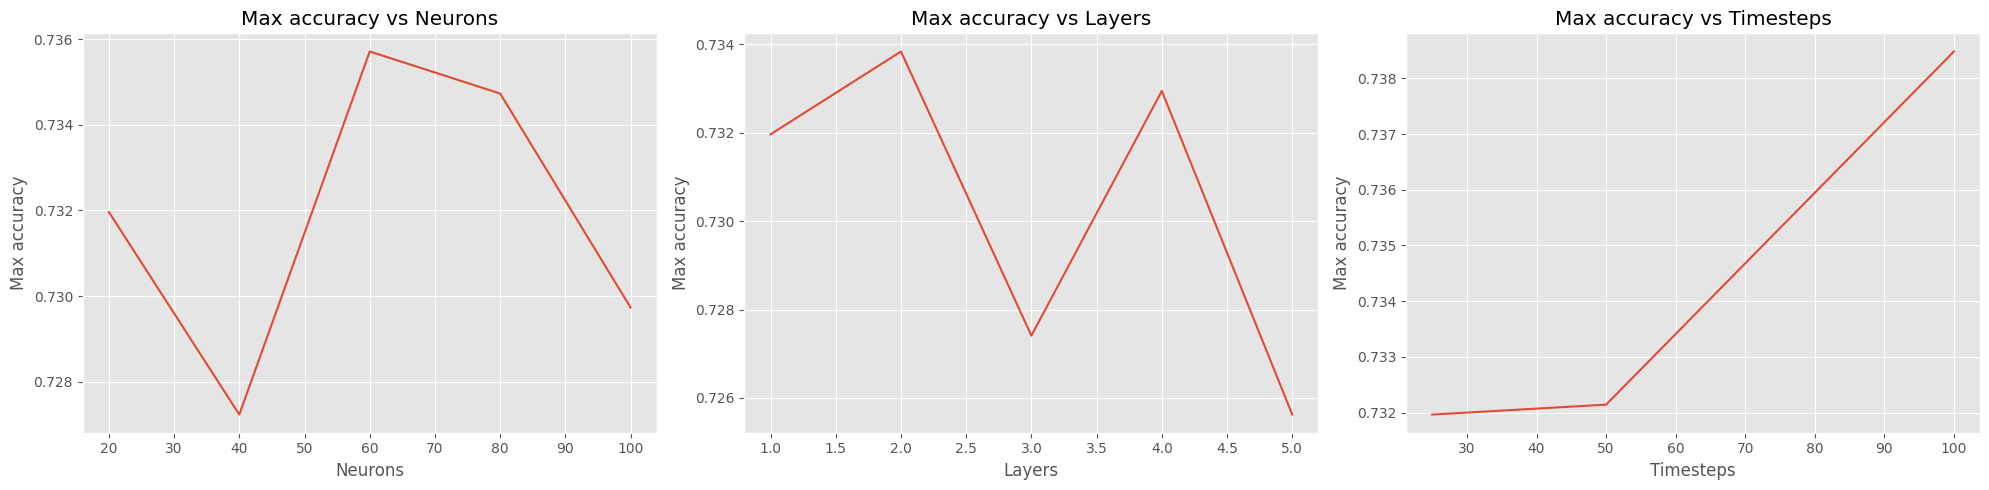

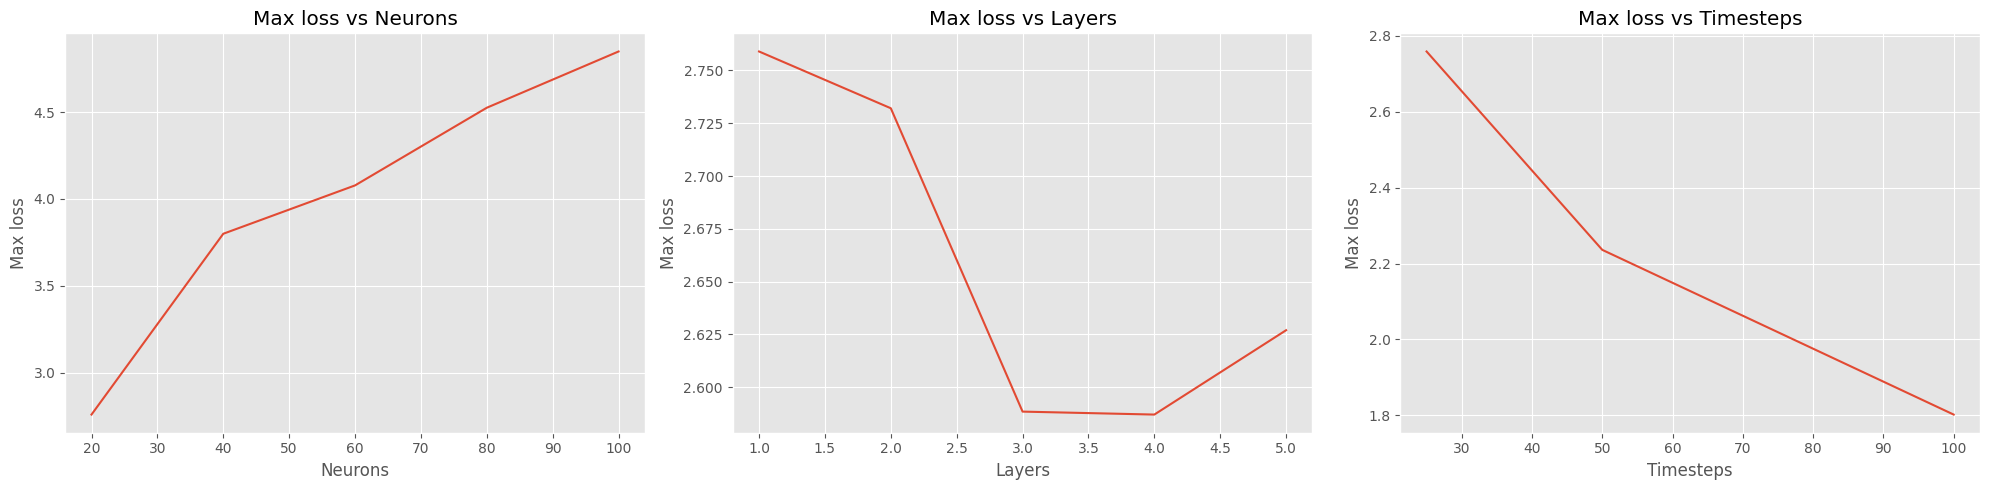

In [134]:
plot_metrics(metric='accuracy', is_train=True)
plot_metrics(metric='loss', is_train=True)

### Predictions

14/14 [==============================] - 0s 2ms/step


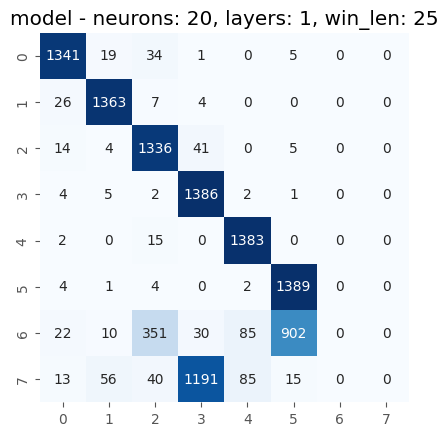

7/7 [==============================] - 3s 4ms/step


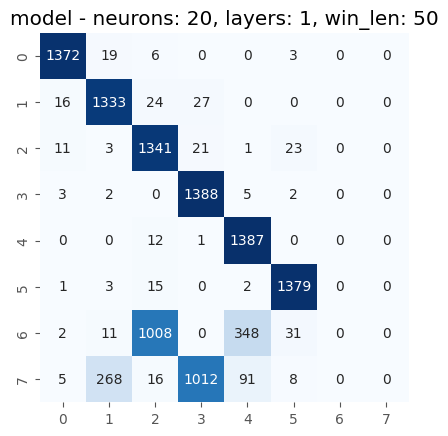

4/4 [==============================] - 0s 5ms/step


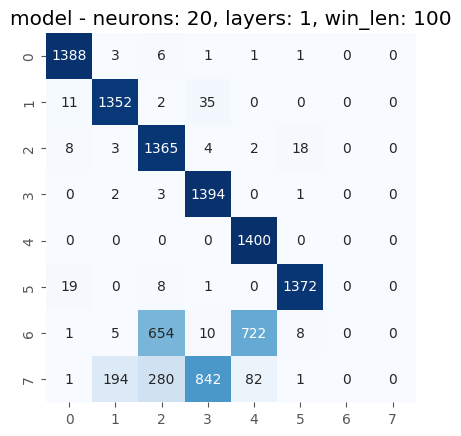

14/14 [==============================] - 0s 4ms/step


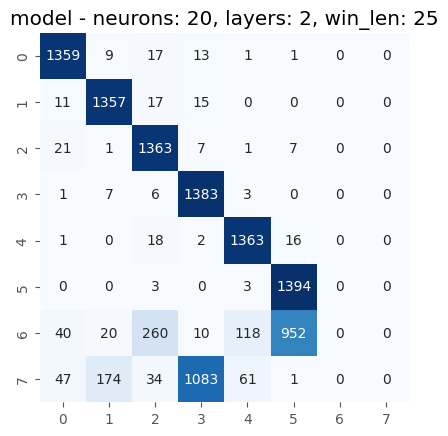

7/7 [==============================] - 0s 5ms/step


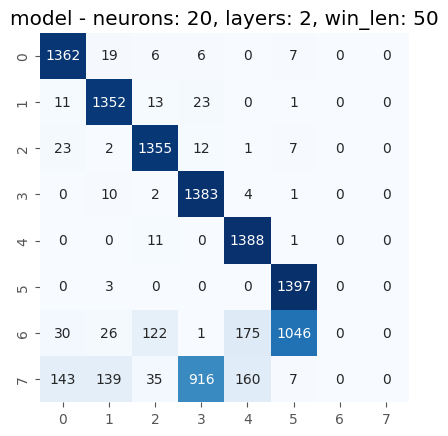

4/4 [==============================] - 0s 8ms/step


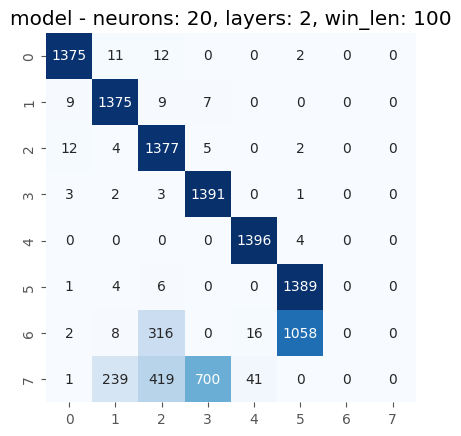

14/14 [==============================] - 1s 4ms/step


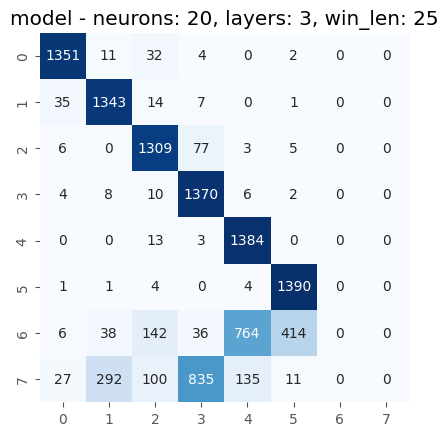

7/7 [==============================] - 1s 7ms/step


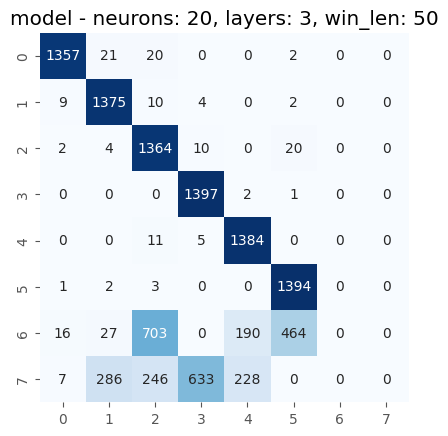

4/4 [==============================] - 1s 13ms/step


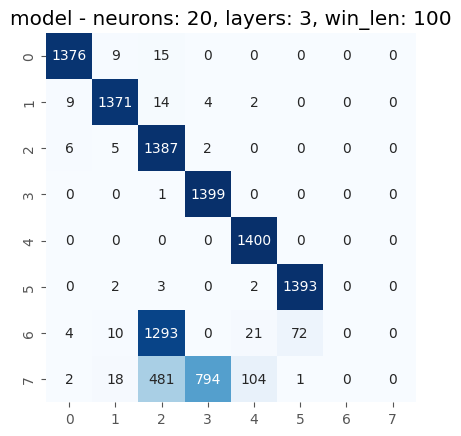

14/14 [==============================] - 1s 6ms/step


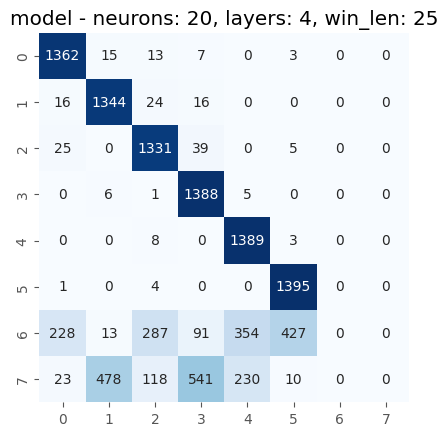

7/7 [==============================] - 1s 10ms/step


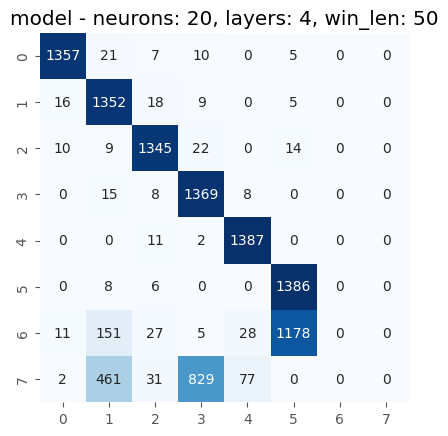

4/4 [==============================] - 1s 15ms/step


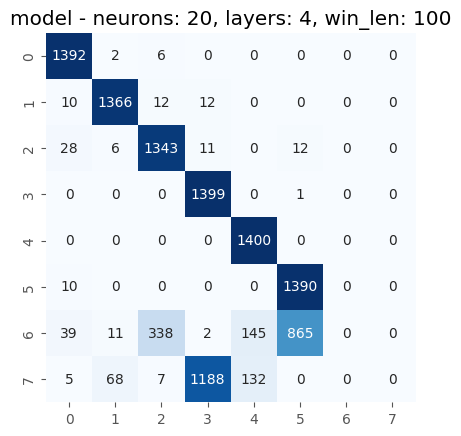

14/14 [==============================] - 1s 6ms/step


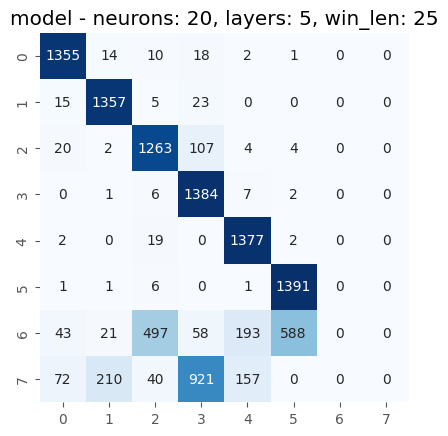

7/7 [==============================] - 1s 12ms/step


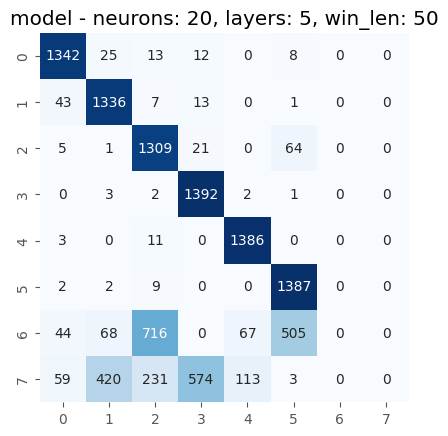

4/4 [==============================] - 1s 20ms/step


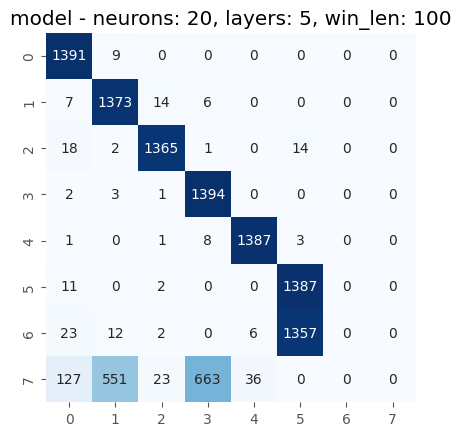

14/14 [==============================] - 0s 3ms/step


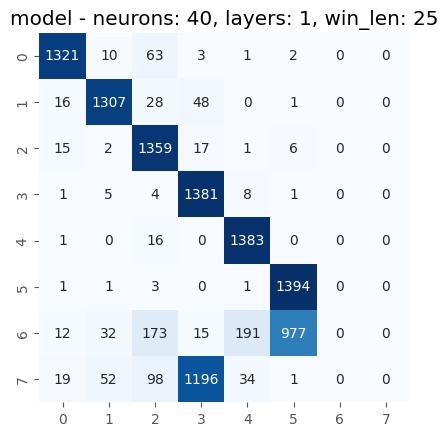

7/7 [==============================] - 0s 4ms/step


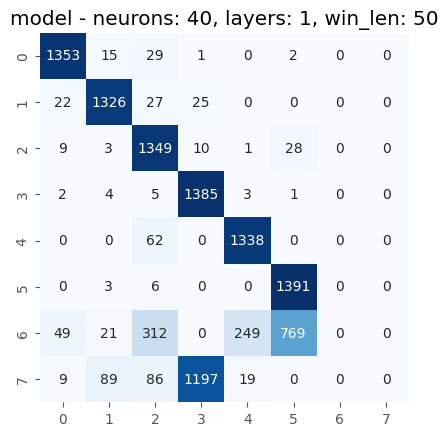

4/4 [==============================] - 0s 7ms/step


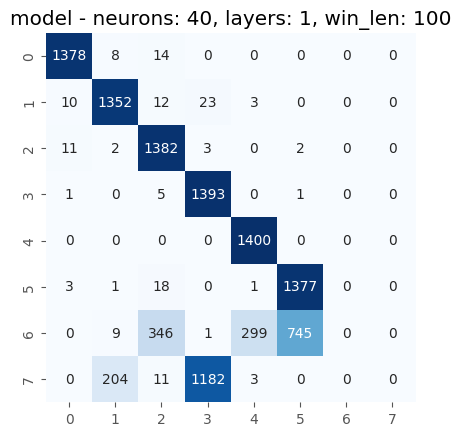

14/14 [==============================] - 0s 4ms/step


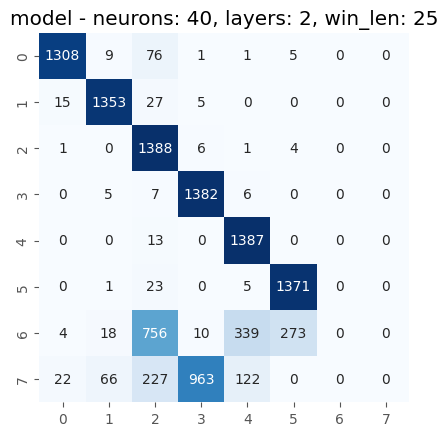

7/7 [==============================] - 0s 6ms/step


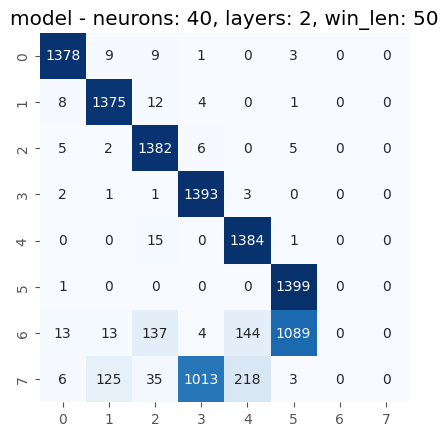

4/4 [==============================] - 0s 11ms/step


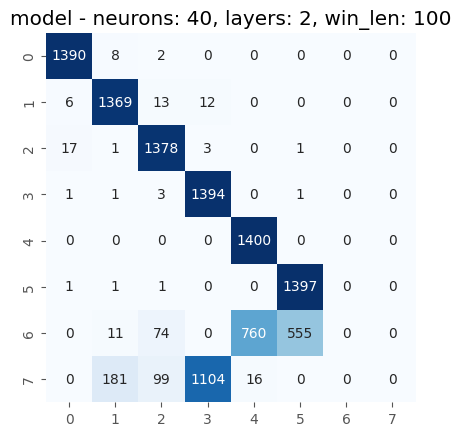

14/14 [==============================] - 1s 5ms/step


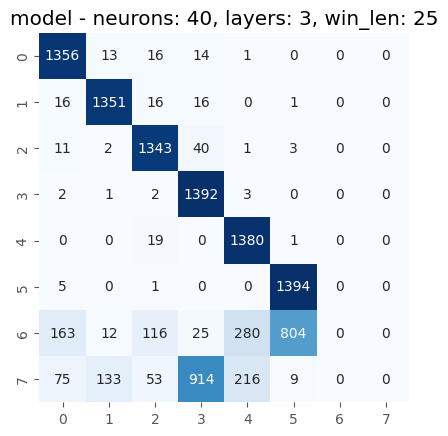

7/7 [==============================] - 1s 9ms/step


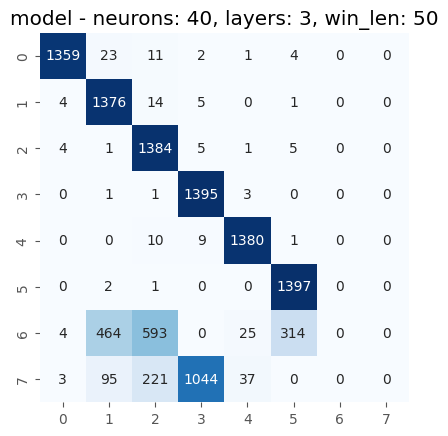

4/4 [==============================] - 1s 15ms/step


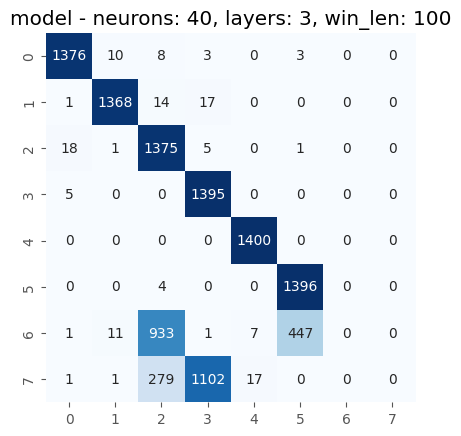

14/14 [==============================] - 1s 6ms/step


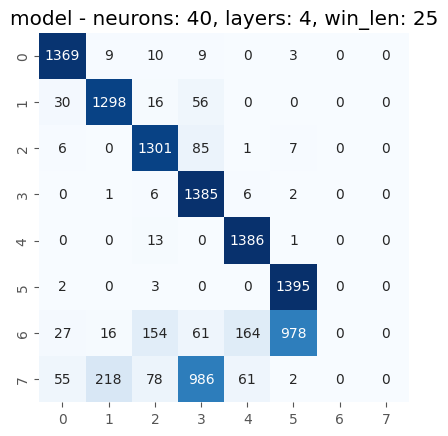

7/7 [==============================] - 1s 13ms/step


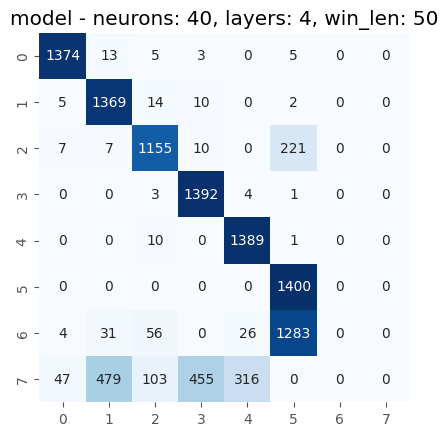

4/4 [==============================] - 1s 19ms/step


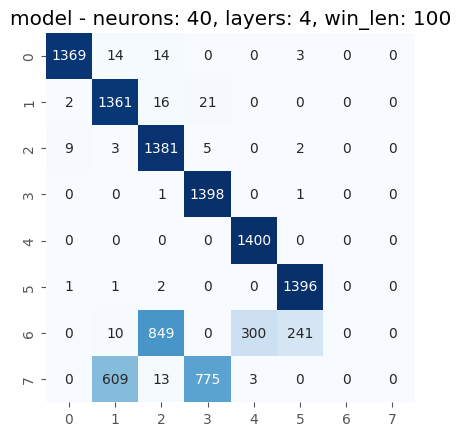

14/14 [==============================] - 1s 8ms/step


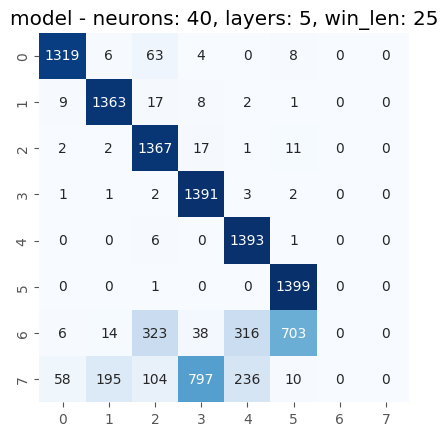

7/7 [==============================] - 1s 15ms/step


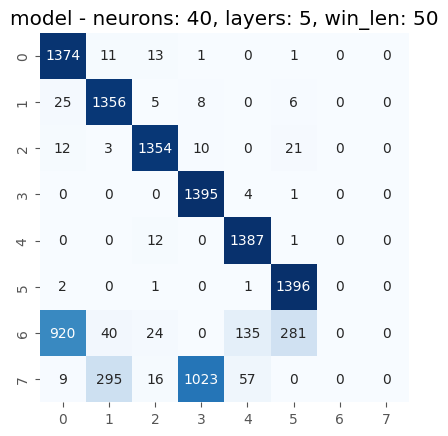

4/4 [==============================] - 1s 26ms/step


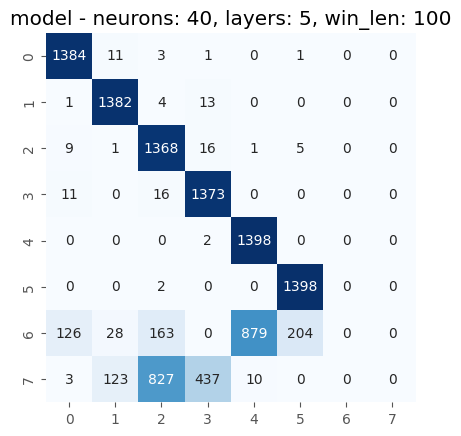

14/14 [==============================] - 0s 3ms/step


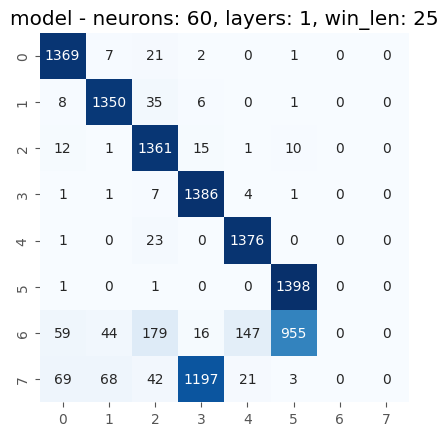

7/7 [==============================] - 0s 5ms/step


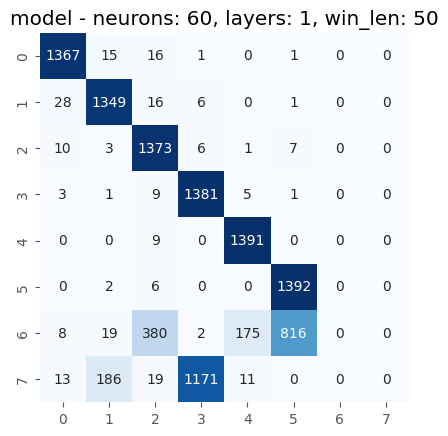

4/4 [==============================] - 0s 9ms/step


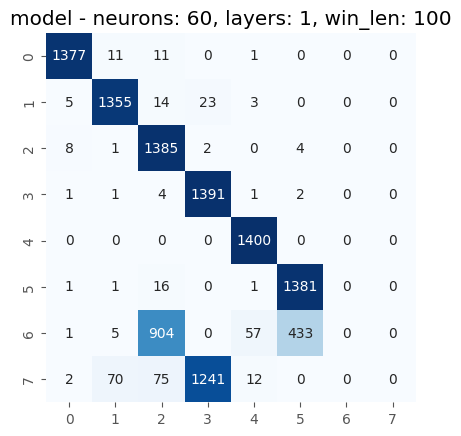

14/14 [==============================] - 0s 5ms/step


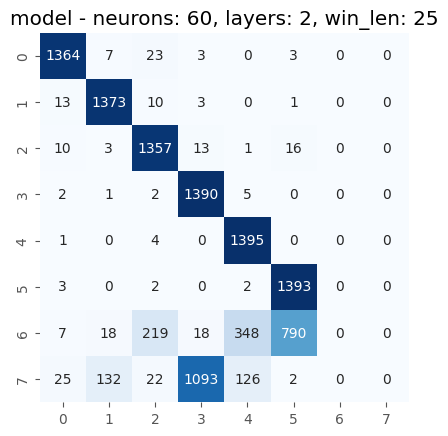

7/7 [==============================] - 0s 8ms/step


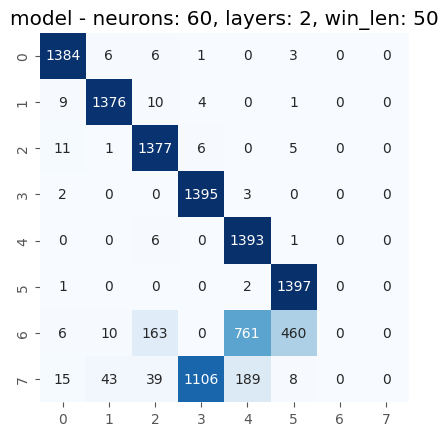

4/4 [==============================] - 0s 14ms/step


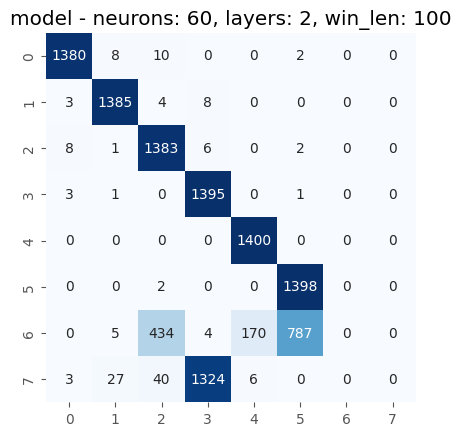

14/14 [==============================] - 1s 6ms/step


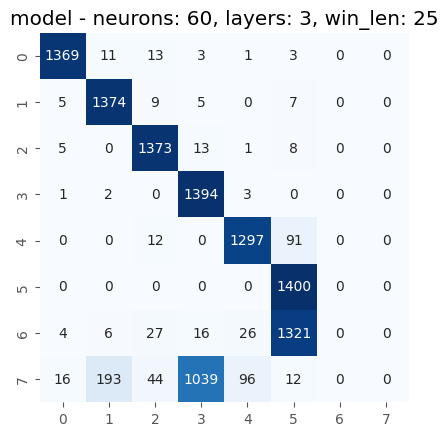

7/7 [==============================] - 1s 12ms/step


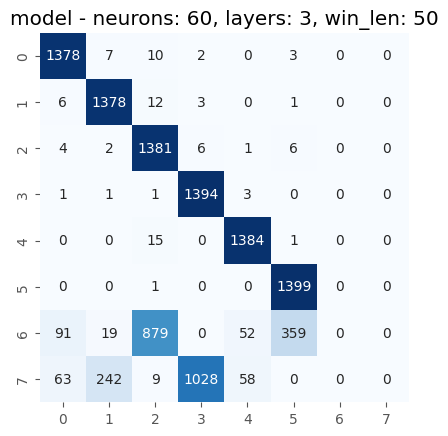

4/4 [==============================] - 1s 21ms/step


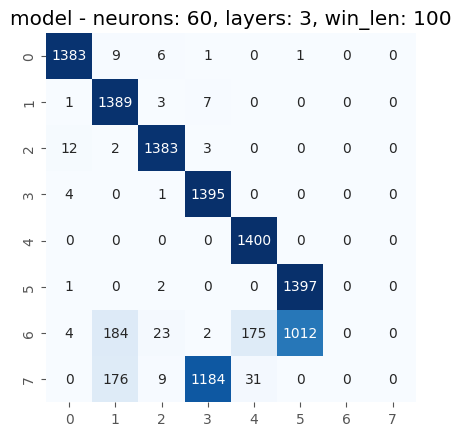

14/14 [==============================] - 1s 9ms/step


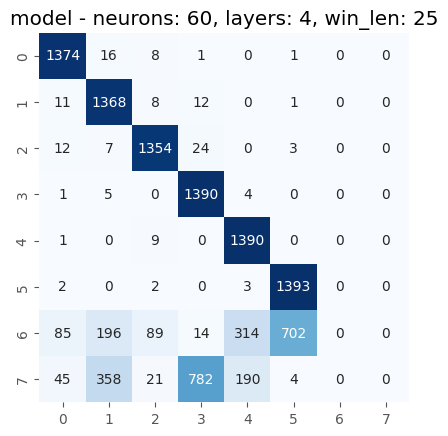

7/7 [==============================] - 1s 17ms/step


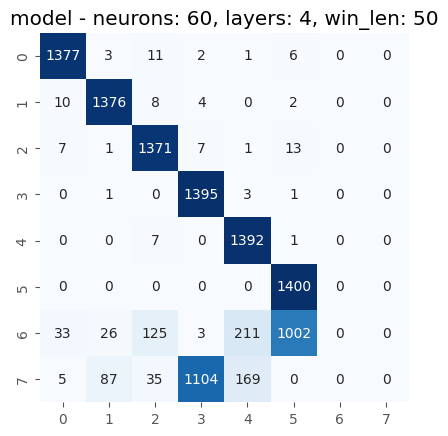

4/4 [==============================] - 1s 27ms/step


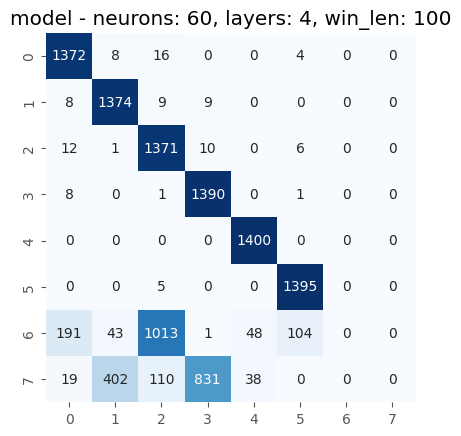

14/14 [==============================] - 1s 12ms/step


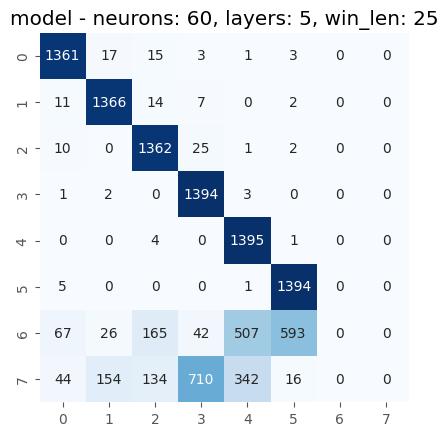

7/7 [==============================] - 1s 21ms/step


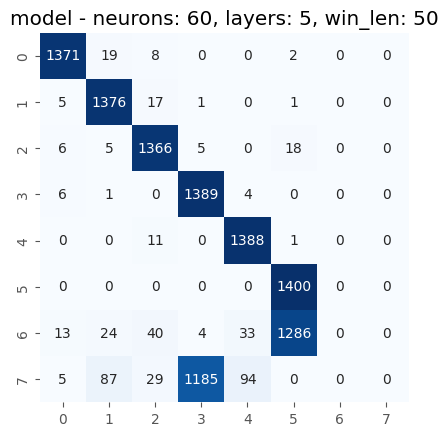

4/4 [==============================] - 1s 35ms/step


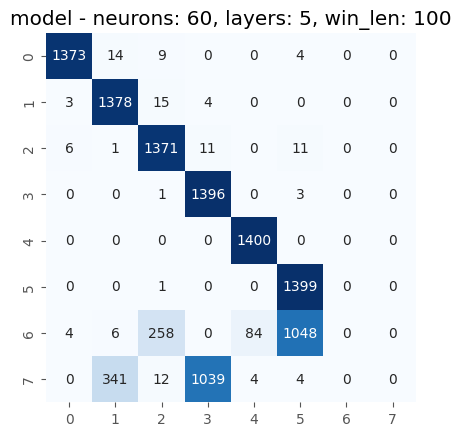

14/14 [==============================] - 0s 3ms/step


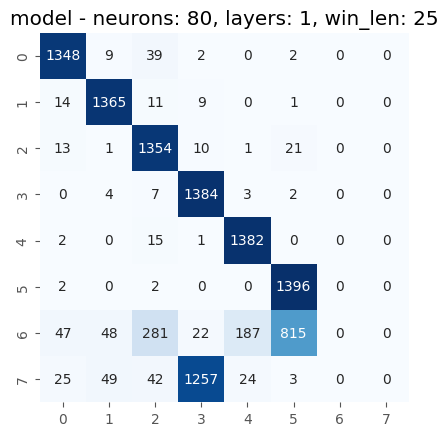

7/7 [==============================] - 0s 5ms/step


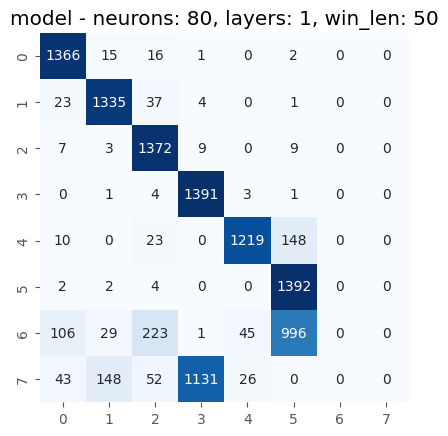

4/4 [==============================] - 0s 8ms/step


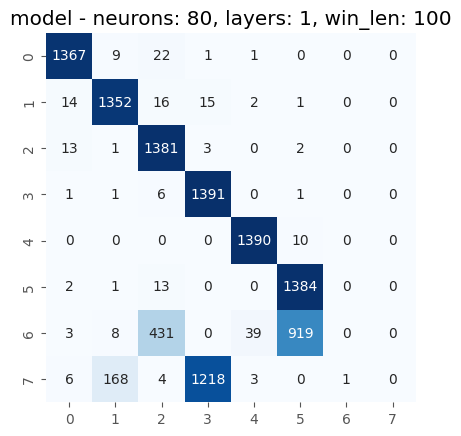

14/14 [==============================] - 0s 6ms/step


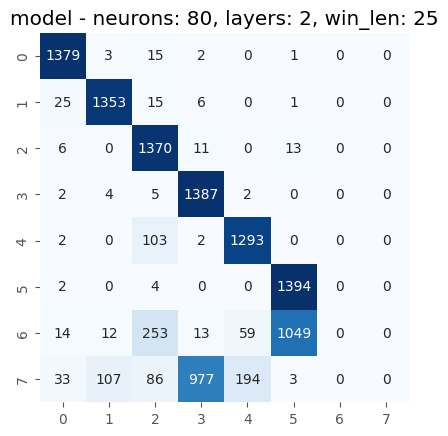

7/7 [==============================] - 0s 10ms/step


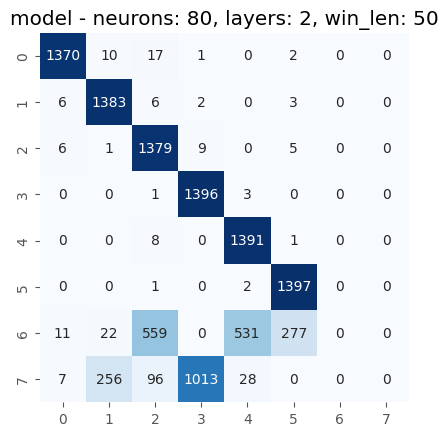

4/4 [==============================] - 0s 16ms/step


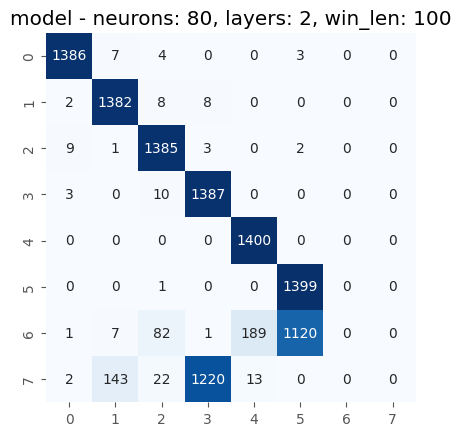

14/14 [==============================] - 1s 8ms/step


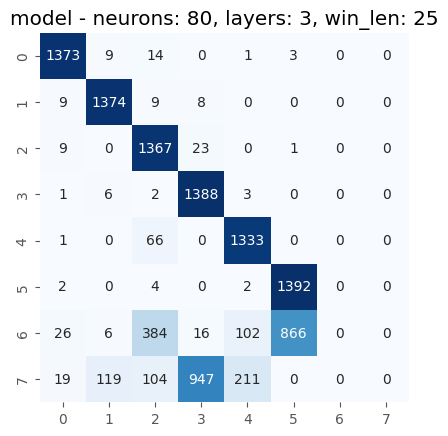

7/7 [==============================] - 1s 15ms/step


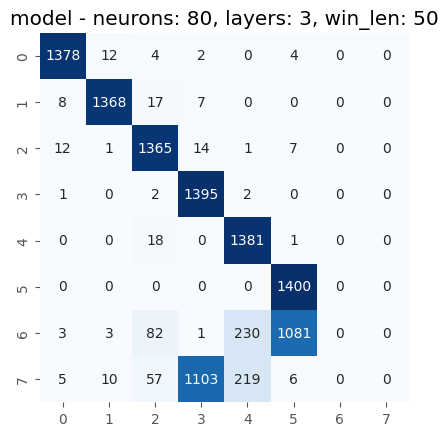

4/4 [==============================] - 1s 23ms/step


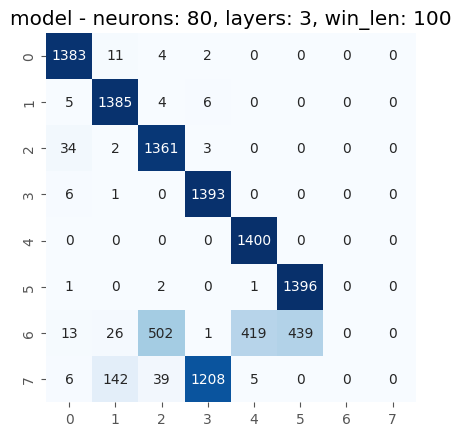

14/14 [==============================] - 1s 10ms/step


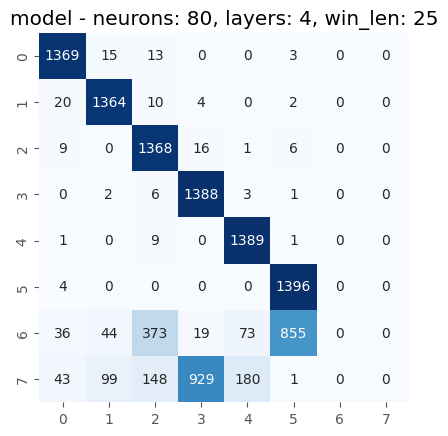

7/7 [==============================] - 1s 20ms/step


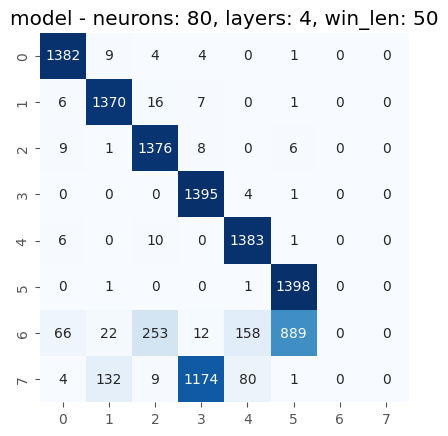

4/4 [==============================] - 1s 33ms/step


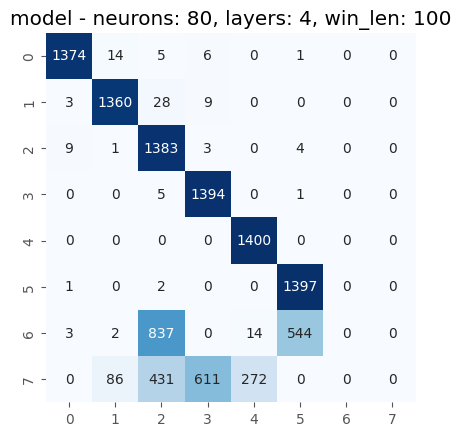

14/14 [==============================] - 1s 13ms/step


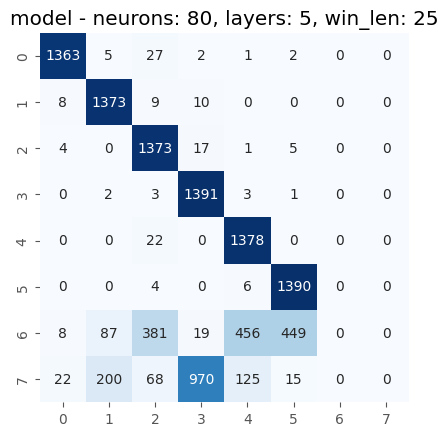

7/7 [==============================] - 1s 23ms/step


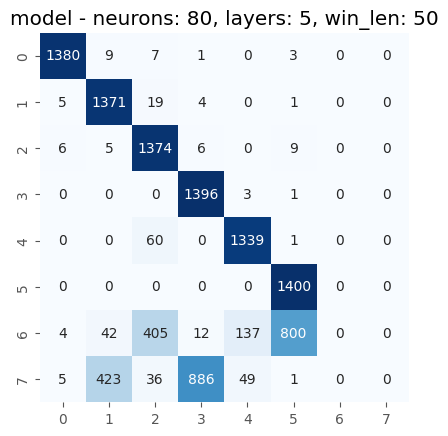

4/4 [==============================] - 1s 38ms/step


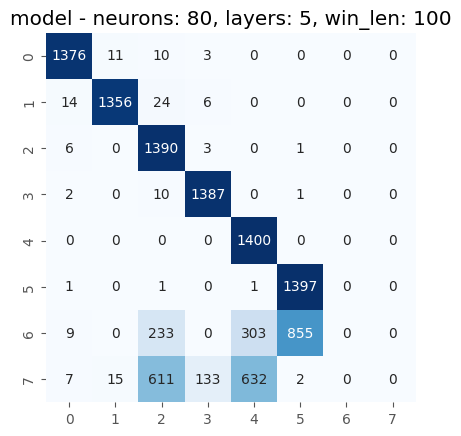

14/14 [==============================] - 0s 4ms/step


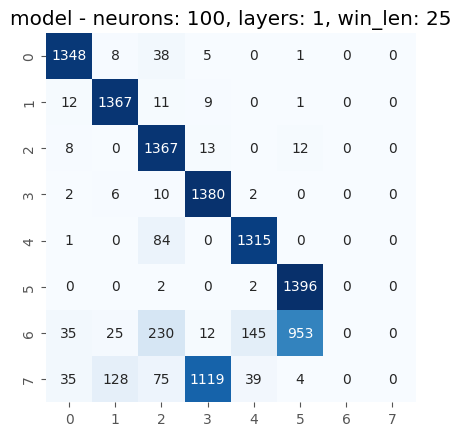

7/7 [==============================] - 0s 7ms/step


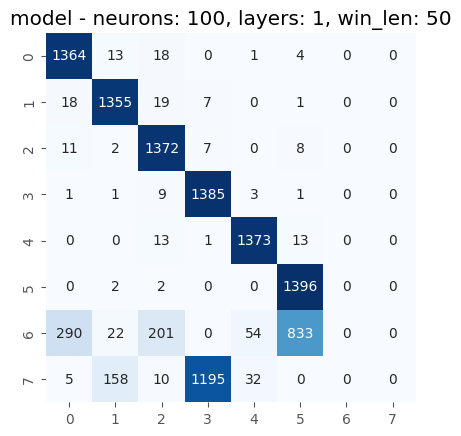

4/4 [==============================] - 0s 11ms/step


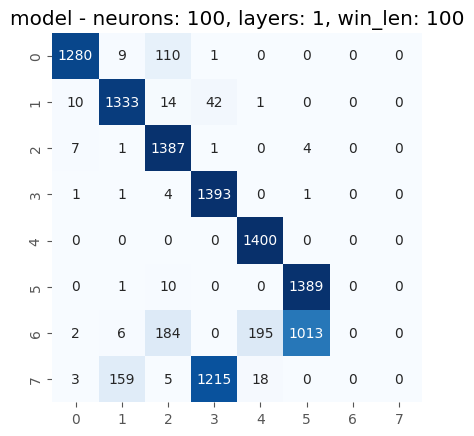

14/14 [==============================] - 0s 8ms/step


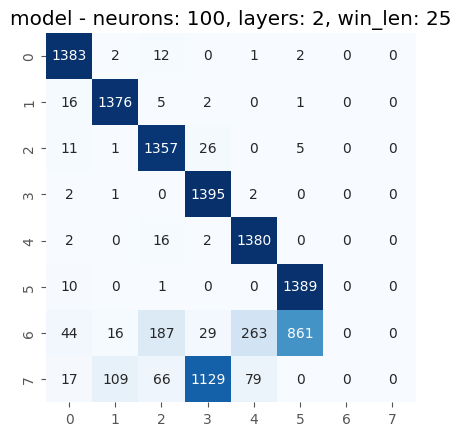

7/7 [==============================] - 0s 14ms/step


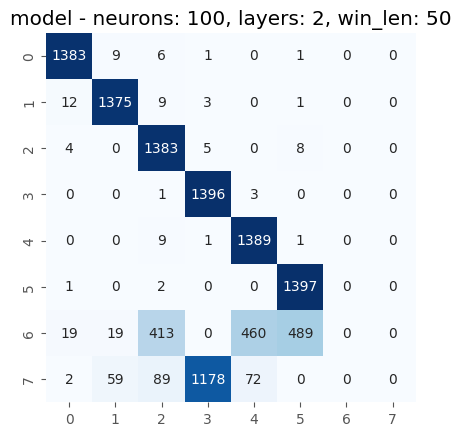

4/4 [==============================] - 1s 26ms/step


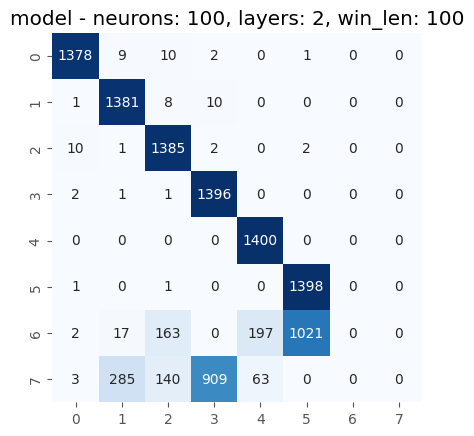

14/14 [==============================] - 1s 11ms/step


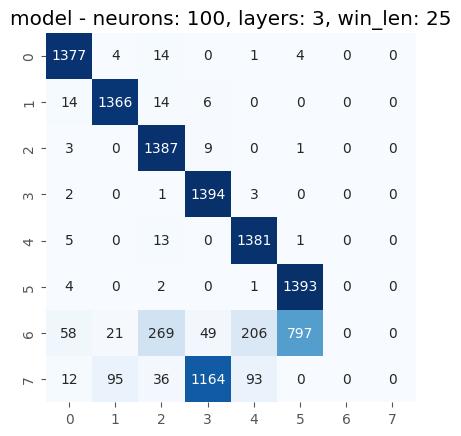

7/7 [==============================] - 1s 22ms/step


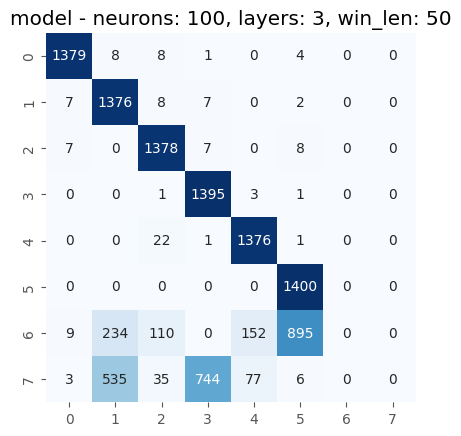

4/4 [==============================] - 1s 37ms/step


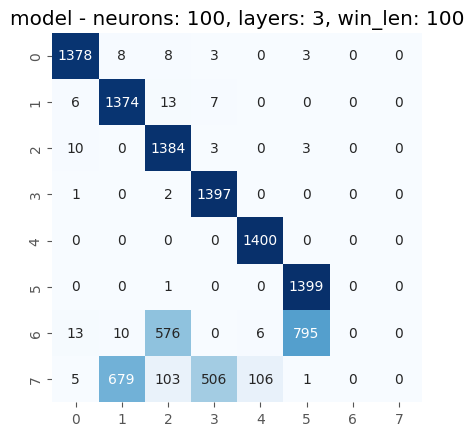

14/14 [==============================] - 1s 16ms/step


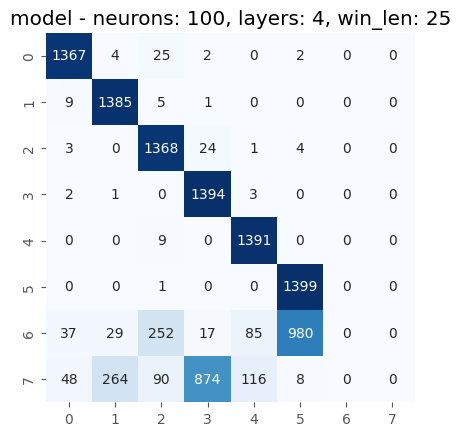

7/7 [==============================] - 1s 29ms/step


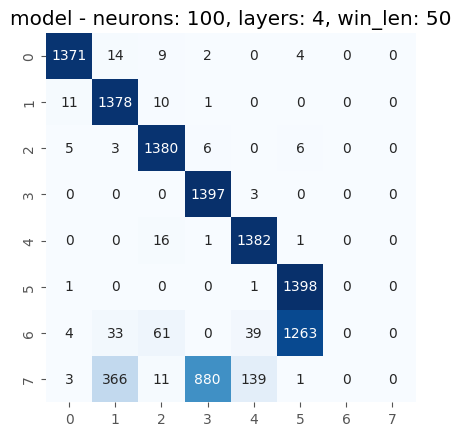

4/4 [==============================] - 1s 51ms/step


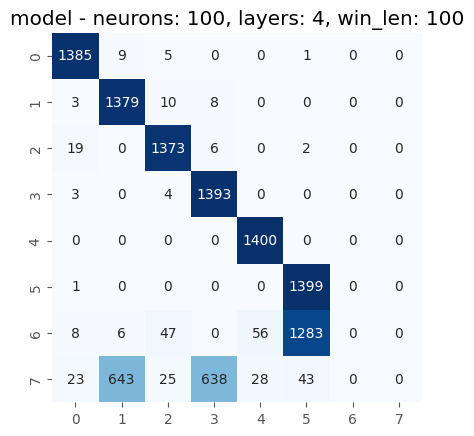

14/14 [==============================] - 1s 18ms/step


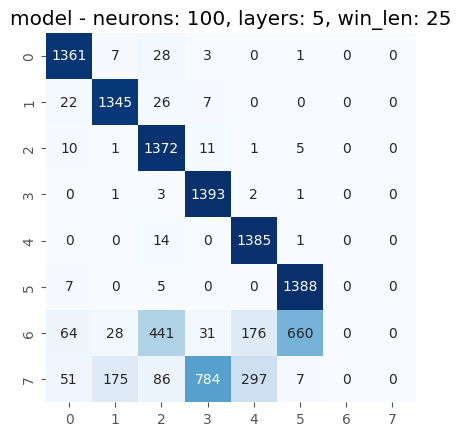

7/7 [==============================] - 1s 33ms/step


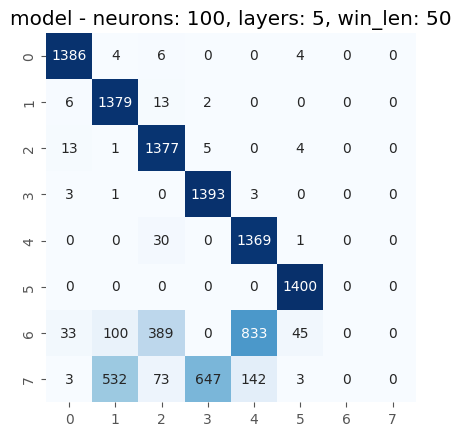

4/4 [==============================] - 1s 60ms/step


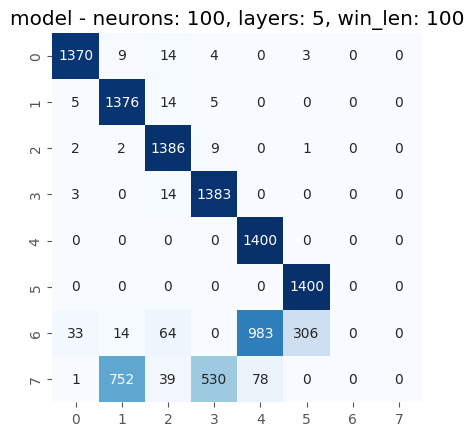

In [135]:
for key, model in models.items():
    _, _, timestep = parse_key(key)
    X_tes, y_tes = test_sets[timestep]

    predicated_probabilities = model.predict(X_tes)
    sns_cm(y_true= y_tes.argmax(axis=2).flatten(), y_pred= predicated_probabilities.argmax(axis=2).flatten())
    plt.title(key)
    plt.show()